In [25]:
# Importar bibliotecas e configurar estilo visual corporativo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [26]:
# Configurações de exibição e estilo "corporativo"
plt.rcParams.update({
    "figure.figsize": (12,5),
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "figure.facecolor": "white",
})
sns.set_style("whitegrid")  # fundo limpo e grade sutil
BLUE = "#0b5fa5"            # azul corporativo principal
ORANGE = "#d97b00"          # tom complement
GRAY = "#6e6e6e"


In [27]:
# Carregar arquivo CSV (assegure que 'dados_ficticios_vendas.csv' está na mesma pasta)
df = pd.read_csv('dados_ficticios_vendas.csv')

In [28]:
# Exibir info e primeiras linhas para inspeção rápida
print("Dimensão:", df.shape)
display(df.info())


Dimensão: (2190, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2190 non-null   object 
 1   product_id        2190 non-null   object 
 2   product_category  2190 non-null   object 
 3   store_id          2190 non-null   object 
 4   sales             2190 non-null   int64  
 5   revenue           2190 non-null   float64
 6   customers         2190 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 119.9+ KB


None

In [29]:
df.head()

,date,product_id,product_category,store_id,sales,revenue,customers
0,2022-01-01,P001,Eletrônicos,S03,15,1091.48,27
1,2022-01-02,P001,Eletrônicos,S04,15,1212.74,19
2,2022-01-03,P001,Eletrônicos,S01,18,116.14,6
3,2022-01-04,P001,Eletrônicos,S03,15,1545.91,16
4,2022-01-05,P001,Eletrônicos,S03,24,1454.73,40


In [30]:
# Garantir que a coluna de data está em datetime, remover linhas inválidas e ordenar
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)


In [31]:
# Verificar se 'sales' e 'revenue' são numéricos; converter se necessário
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

In [32]:
# Remover possíveis linhas sem sales/revenue
df = df.dropna(subset=['sales', 'revenue']).reset_index(drop=True)


In [33]:
# Exibir resumo
df.describe(include='all')

,date,product_id,product_category,store_id,sales,revenue,customers
count,2190,2190,2190,2190,2190.000000,2190.000000,2190.000000
unique,NaN,3,3,4,NaN,NaN,NaN
top,NaN,P001,Eletrônicos,S01,NaN,NaN,NaN
freq,NaN,730,730,574,NaN,NaN,NaN
mean,2022-12-31 12:00:00,NaN,NaN,NaN,19.968493,1023.852995,26.923744
min,2022-01-01 00:00:00,NaN,NaN,NaN,8.000000,100.460000,5.000000
25%,2022-07-02 00:00:00,NaN,NaN,NaN,17.000000,558.635000,16.000000
50%,2022-12-31 12:00:00,NaN,NaN,NaN,20.000000,1003.845000,27.000000
75%,2023-07-02 00:00:00,NaN,NaN,NaN,23.000000,1482.187500,38.000000
max,2023-12-31 00:00:00,NaN,NaN,NaN,35.000000,1998.490000,49.000000


In [34]:
# Para reduzir ruído e deixar os gráficos mais limpos, calculamos média móvel de 7 dias
window = 7  # média móvel semanal (ajustável)
df['sales_smooth'] = df['sales'].rolling(window=window, center=True, min_periods=1).mean()
df['revenue_smooth'] = df['revenue'].rolling(window=window, center=True, min_periods=1).mean()


In [35]:

# Exibir amostra com colunas novas
df[['date','sales','sales_smooth','revenue','revenue_smooth']].head(10)

,date,sales,sales_smooth,revenue,revenue_smooth
0,2022-01-01,15,15.250000,1091.48,864.385000
1,2022-01-01,13,16.200000,201.80,764.898000
2,2022-01-01,18,16.666667,951.52,855.701667
3,2022-01-02,15,16.857143,1212.74,750.050000
4,2022-01-02,20,18.714286,366.95,777.387143
5,2022-01-02,19,20.428571,1309.72,822.894286
6,2022-01-03,18,21.142857,116.14,757.658571
7,2022-01-03,28,22.571429,1282.84,782.472857
8,2022-01-03,25,21.857143,520.35,950.895714
9,2022-01-04,23,21.571429,494.87,987.687143


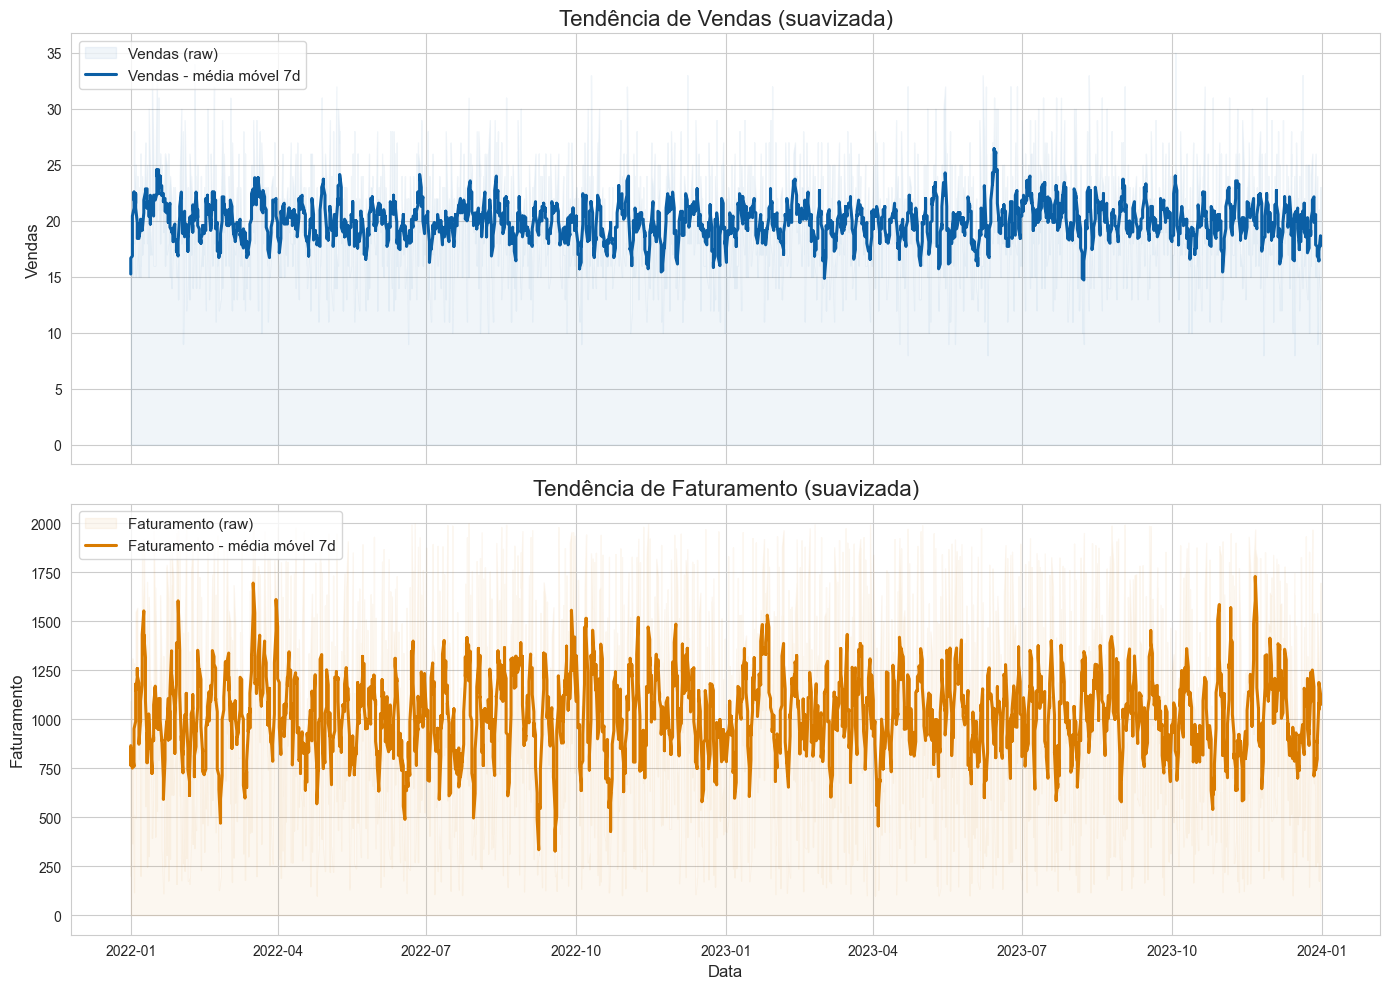

In [36]:
# Gráfico corporativo: mostrar série bruta como área clara + linha suavizada em destaque
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True)

# VENDAS
axes[0].fill_between(df['date'], df['sales'], alpha=0.06, color=BLUE, label='Vendas (raw)')
axes[0].plot(df['date'], df['sales_smooth'], color=BLUE, linewidth=2.2, label=f'Vendas - média móvel {window}d')
axes[0].set_title('Tendência de Vendas (suavizada)')
axes[0].set_ylabel('Vendas')
axes[0].legend(loc='upper left')

# FATURAMENTO
axes[1].fill_between(df['date'], df['revenue'], alpha=0.06, color=ORANGE, label='Faturamento (raw)')
axes[1].plot(df['date'], df['revenue_smooth'], color=ORANGE, linewidth=2.2, label=f'Faturamento - média móvel {window}d')
axes[1].set_title('Tendência de Faturamento (suavizada)')
axes[1].set_ylabel('Faturamento')
axes[1].legend(loc='upper left')

plt.xlabel('Data')
plt.tight_layout()
plt.show()


In [37]:
# Prophet exige colunas 'ds' (data) e 'y' (valor a prever)
df_sales = df[['date','sales']].rename(columns={'date':'ds','sales':'y'}).copy()
df_revenue = df[['date','revenue']].rename(columns={'date':'ds','revenue':'y'}).copy()

# Conferir
print("Sales:", df_sales.shape)
print("Revenue:", df_revenue.shape)
df_sales.head()


Sales: (2190, 2)
Revenue: (2190, 2)


,ds,y
0,2022-01-01,15
1,2022-01-01,13
2,2022-01-01,18
3,2022-01-02,15
4,2022-01-02,20


In [38]:
from prophet.diagnostics import performance_metrics

def train_and_predict_prophet(df_ts, periods=30, yearly=True, weekly=True):
    """
    Treina Prophet em df_ts (colunas ds, y) e retorna modelo, forecast (df), e dataframe futuro.
    periods: número de dias futuros a prever
    """
    model = Prophet(yearly_seasonality=yearly, weekly_seasonality=weekly, daily_seasonality=False,
                    seasonality_mode='additive')
    model.fit(df_ts)
    futuro = model.make_future_dataframe(periods=periods)
    forecast = model.predict(futuro)
    return model, forecast, futuro

# Teste rápido (não executa até você rodar a célula seguinte)


In [39]:
# Treinar e prever para 'sales' com horizon de 30 dias
modelo_sales, previsao_sales, futuro_sales = train_and_predict_prophet(df_sales, periods=30)

# Mostrar últimas linhas da previsão
previsao_sales[['ds','yhat','yhat_lower','yhat_upper']].tail()


14:50:35 - cmdstanpy - INFO - Chain [1] start processing
14:50:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
755,2024-01-26,21.009705,15.313061,26.743336
756,2024-01-27,20.614319,14.941417,26.195015
757,2024-01-28,19.963540,14.710169,25.734789
758,2024-01-29,20.659338,14.961022,26.433899
759,2024-01-30,20.339688,14.562185,26.048150


In [40]:
# Treinar e prever para 'revenue' com horizon de 30 dias
modelo_revenue, previsao_revenue, futuro_revenue = train_and_predict_prophet(df_revenue, periods=30)

previsao_revenue[['ds','yhat','yhat_lower','yhat_upper']].tail()


14:50:36 - cmdstanpy - INFO - Chain [1] start processing
14:50:36 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
755,2024-01-26,1108.084131,399.321057,1810.982997
756,2024-01-27,1030.902288,348.862258,1686.743093
757,2024-01-28,1093.993984,398.229722,1809.251254
758,2024-01-29,1119.529867,411.365525,1807.207332
759,2024-01-30,1120.943818,457.067544,1823.335712


In [41]:
def plot_prophet_results(model, forecast, df_raw, column_label='Valor', smooth_col=None):
    """
    model: objeto Prophet treinado
    forecast: DataFrame retornado por model.predict
    df_raw: DataFrame original com colunas 'ds' e 'y' (valores reais)
    column_label: rótulo do eixo y
    smooth_col: coluna opcional em df_raw com série suavizada para sobrepor (ex: sales_smooth)
    """
    # Juntar previsões e reais
    plot_df = forecast[['ds','yhat','yhat_lower','yhat_upper']].merge(df_raw, on='ds', how='left')
    
    # Plot
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Faixa de confiança
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color=BLUE, alpha=0.12, label='Intervalo de confiança')
    
    # Forecast line (apenas até o futuro)
    ax.plot(forecast['ds'], forecast['yhat'], linestyle='--', linewidth=2.0, color=BLUE, label='Previsão (yhat)')
    
    # Real (valores históricos) — mostrar como linha fina e pontilhada levemente
    ax.plot(df_raw['ds'], df_raw['y'], color=GRAY, linewidth=0.8, alpha=0.6, label='Valores reais (raw)')
    
    # Se houver uma série suavizada, destacar em cor de destaque
    if smooth_col is not None and smooth_col in df.columns:
        # pegar df original pela coluna ds e smooth_col
        ax.plot(df['date'], df[smooth_col], color=BLUE, linewidth=2.2, label='Série suavizada (média móvel)')
    
    # Estética
    ax.set_title(f'Previsão — {column_label}', fontsize=16)
    ax.set_xlabel('Data')
    ax.set_ylabel(column_label)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


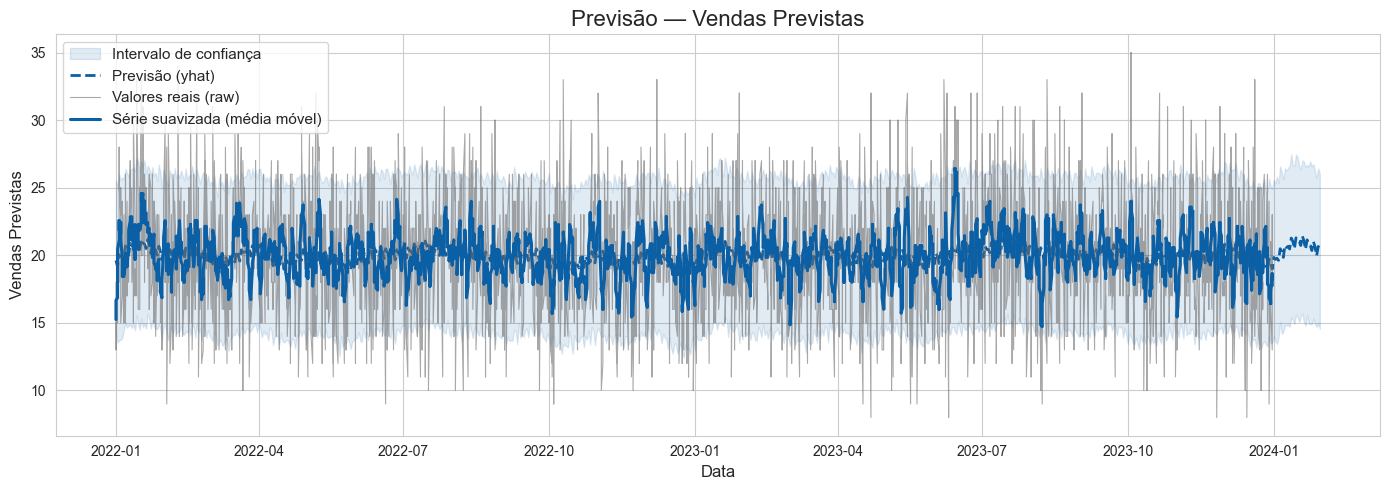

In [42]:
# Criar df_sales no formato esperado (cópia)
df_sales_plot = df_sales.copy()

# Plot: usamos coluna 'sales_smooth' como smooth_col (ela está no df original)
plot_prophet_results(modelo_sales, previsao_sales, df_sales_plot, column_label='Vendas Previstas', smooth_col='sales_smooth')


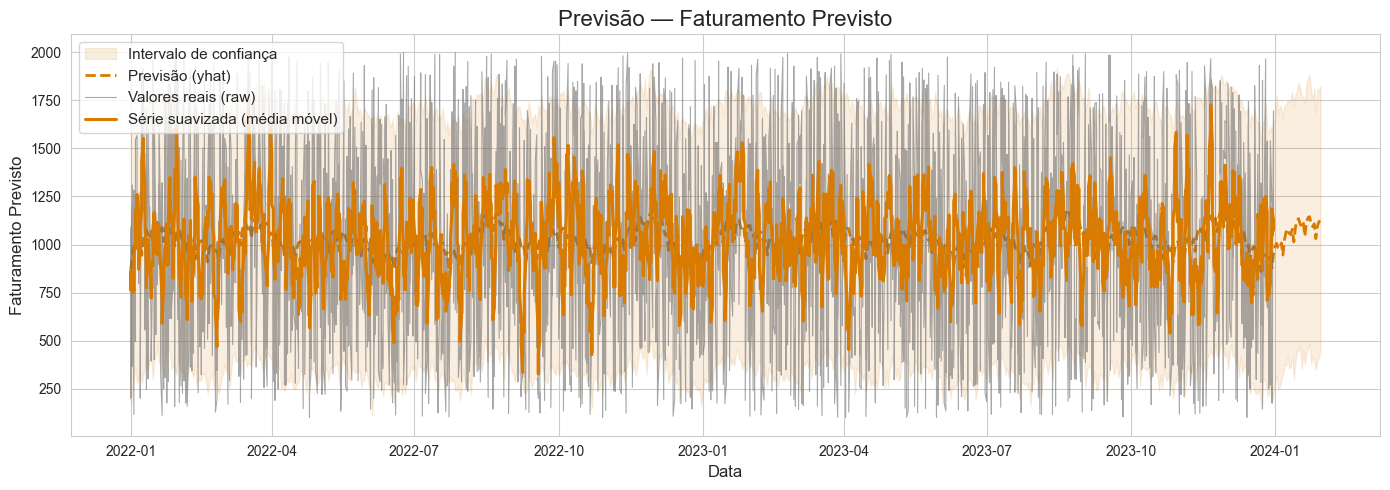

In [43]:
# Preparar df_revenue para plot
df_revenue_plot = df_revenue.copy()

# Alterar cor do plot_prophet_results para usar ORANGE para revenue
# Simplest approach: temporarily swap BLUE variable (we'll restore afterwards)
_old_blue = BLUE
BLUE = ORANGE

plot_prophet_results(modelo_revenue, previsao_revenue, df_revenue_plot, column_label='Faturamento Previsto', smooth_col='revenue_smooth')

# restaurar BLUE
BLUE = _old_blue


MAE — Vendas: 3.59
MAE — Faturamento: 461.54


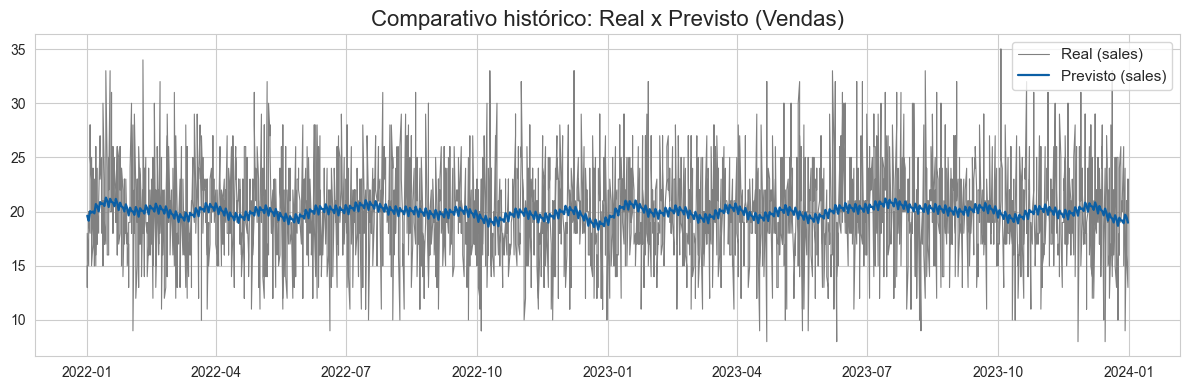

In [44]:
# Avaliar MAE apenas no período histórico (onde y existe)
def compute_mae(forecast, df_ts):
    merged = forecast[['ds','yhat']].merge(df_ts, on='ds', how='left')
    merged = merged.dropna(subset=['y'])  # manter apenas datas com valor real
    mae = np.mean(np.abs(merged['y'] - merged['yhat']))
    return mae, merged

mae_sales, merged_sales = compute_mae(previsao_sales, df_sales)
mae_revenue, merged_revenue = compute_mae(previsao_revenue, df_revenue)

print(f"MAE — Vendas: {mae_sales:.2f}")
print(f"MAE — Faturamento: {mae_revenue:.2f}")

# Opcional: plot comparativo pequeno (real x previsto histórico)
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(merged_sales['ds'], merged_sales['y'], label='Real (sales)', color='gray', linewidth=0.8)
ax.plot(merged_sales['ds'], merged_sales['yhat'], label='Previsto (sales)', color=BLUE, linewidth=1.6)
ax.set_title('Comparativo histórico: Real x Previsto (Vendas)')
ax.legend()
plt.tight_layout()
plt.show()
